# Spline transformations for images

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import os
import summerschool as ss
import scipy.interpolate as spi

## Minimization problem

We write $\varphi^{-1} = x - v(x)$ and minimize the cost function

\begin{align*}
E = \int \frac{1}{2}v^T(x) A v(x)dx + \int \frac{1}{2\sigma^2} (I(x-v(x)) - J(x))^2dx
\end{align*}

We'll take a perturbation $v \mapsto v + \epsilon \delta v$.
\begin{align*}
&\frac{d}{d\epsilon}\int \frac{1}{2}(v + \epsilon \delta v)^T(x) A (v + \epsilon \delta v)(x)dx + \int \frac{1}{2\sigma^2} (I(x-v(x) - \epsilon \delta v) - J)^2dx \bigg|_{\epsilon = 0}\\
&= \int Av^T(x) \delta v(x)dx + \frac{1}{\sigma^2}\int (I(x - v(x)) - J(x))\frac{d}{d\epsilon} I(x - v(x) - \epsilon \delta v(x))\bigg|_{\epsilon = 0}dx\\
&= \int Av^T(x) \delta v(x)dx + -\frac{1}{\sigma^2}\int (I(x - v(x)) - J(x)) DI(x - v(x))\delta v(x)dx\\
\end{align*}
If this is stationary for all perturbations, we require 
\begin{align*}
DE &= Av(x) - \frac{1}{\sigma^2}(I(x - v(x)) - J(x))\nabla I(x - v(x)) = 0
\end{align*}
We will use this gradient to form a gradient descent algorithm.  Typically acting on this gradient with the inverse of $A$, which is convolution with it's Green's kernel $K$, gives better numerical performance.  We use the gradient vector
\begin{align*}
\nabla E &= v(x) - \frac{1}{\sigma^2}K * (I(x - v(x)) - J(x))\nabla I(x - v(x))
\end{align*}

## Energy operator in the Fourier domain
Let's consider using $A = (id - a^2\Delta)^{2p}$.  How can we find $K$?  How can we do it for discrete images?

Define the discrete laplacian as
\begin{align*}
[\Delta I][i,j,k] &= \frac{1}{dx[0]^2}(I[i+1,j,k] - 2I[i,j,k] + I[i-1,j,k]) + \ldots
\end{align*}
with the same expression for the second and third indices.

Notice that on the right we just have shifts of the original image, which can be encoded in the frequency domain by modulation.
\begin{align*}
 \hat {[\Delta I]}[i,j,k] &= \frac{1}{dx[0]^2}(\hat I[i,j,k] \exp(2\pi \sqrt{-1}f_0[i]dx[0] ) - 2 I[i,j,k] + (\hat I[i,j,k] \exp(-2\pi \sqrt{-1}f_0[i]dx[0] )) + \ldots
\end{align*}
Combine the exponentials using Euler's theorem
\begin{align*}
&= \frac{1}{dx[0]^2}\hat I[i,j,k] (2\cos(2\pi f_0[i] dx[0])-2)+  \ldots
\end{align*}

So we can encode the whole operator in the fourier domain by
\begin{align*}
\hat A[i,j,k] = \left( 1 - 2a^2 \left( \frac{1}{dx[0]^2} (\cos(2\pi f_0[i] dx[0])-1)  \right) + \ldots \right)^{2p}
\end{align*}

Now $\hat K$ is just one over this.
\begin{align*}
\hat K[i,j,k] = \left( 1 - 2a^2 \left( \frac{1}{dx[0]^2} (\cos(2\pi f_0[i] dx[0])-1)  \right) + \ldots\right)^{-2p}
\end{align*}

In [2]:
# load a pair of images
fname = os.path.join('mouse_images','PMD2052_orig_target_STS_clean.img')
imgI = nib.load(fname)
nx = imgI.header['dim'][1:4]
dx = imgI.header['pixdim'][1:4]

fname = os.path.join('mouse_images','PMD3097_orig_target_STS_clean.img')
imgJ = nib.load(fname)

<IPython.core.display.Javascript object>


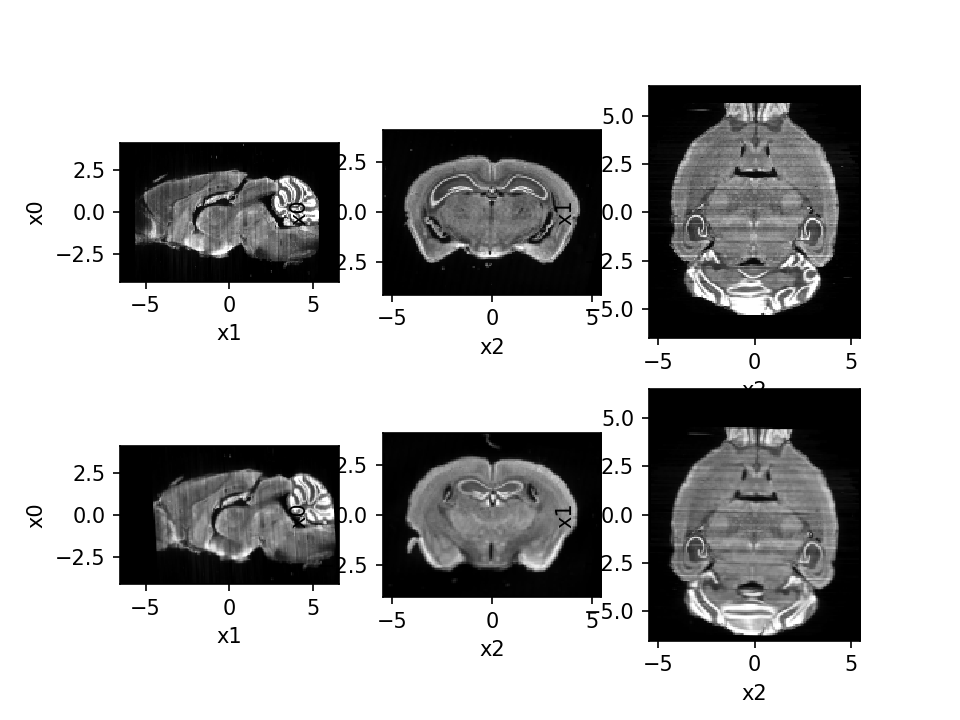

In [3]:
# linearly transform the first to match the second
# load affine from last tutorial and apply it as in last tutorial
A = np.zeros((4,4))
with open('affine.txt','rt') as f:
    for i in range(4):
        line = f.readline()
        A[i,:] = [float(a) for a in line.split()]

x0 = np.arange(nx[0])*dx[0]
x1 = np.arange(nx[1])*dx[1]
x2 = np.arange(nx[2])*dx[2]
x0 = x0 - np.mean(x0)
x1 = x1 - np.mean(x1)
x2 = x2 - np.mean(x2)
X0,X1,X2 = np.meshgrid(x0,x1,x2,indexing='ij')
X0s,X1s,X2s = ss.sample_points_from_affine(X0,X1,X2,A)
interp_args = {
    'method':'linear',
    'bounds_error':False,
    'fill_value':0
    }
AI = spi.interpn([x0,x1,x2],imgI.get_data()[:,:,:,0],np.stack([X0s,X1s,X2s],axis=-1),**interp_args)
f,ax = plt.subplots(2,3)
ss.imshow_slices(x0,x1,x2,imgI.get_data()[:,:,:,0],ax[0])
ss.imshow_slices(x0,x1,x2,AI,ax[1])

<IPython.core.display.Javascript object>


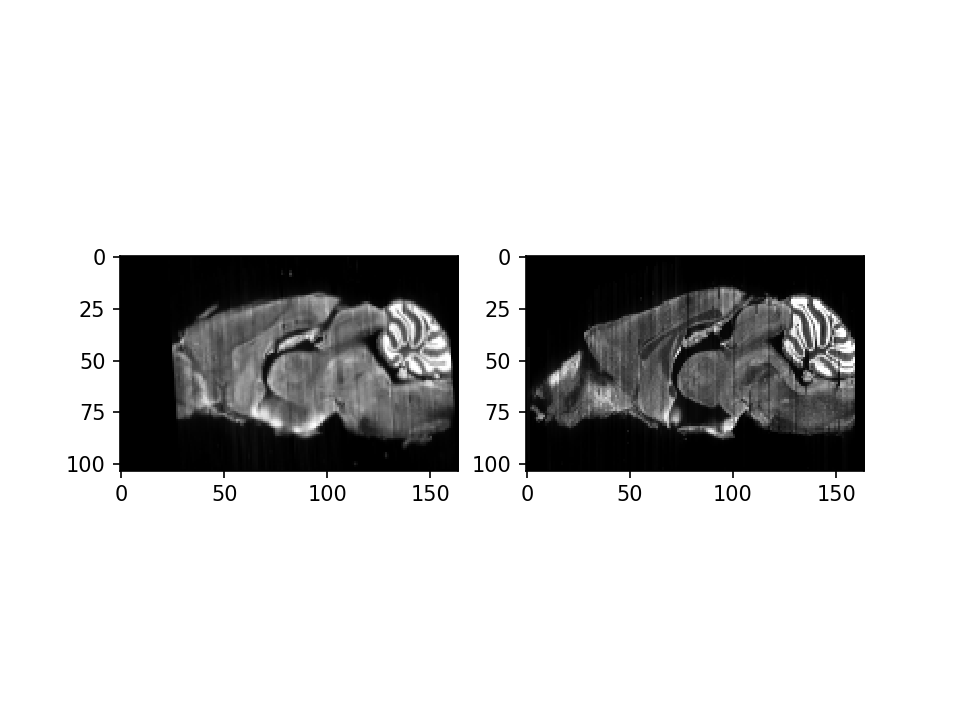

In [4]:
# start with a 2D example
# set up a domain
x0 = np.arange(nx[0])*dx[0]
x1 = np.arange(nx[1])*dx[1]
X0,X1 = np.meshgrid(x0,x1,indexing='ij')

I = AI[:,:,imgI.shape[2]//2]
J = imgJ.get_data()[:,:,imgJ.shape[2]//2,0] # note last axes is time, we'd like to remove it

f,ax = plt.subplots(1,2)
ax[0].imshow(I,cmap='gray')
ax[0].set_aspect('equal')
ax[1].imshow(J,cmap='gray')
ax[1].set_aspect('equal')

<IPython.core.display.Javascript object>


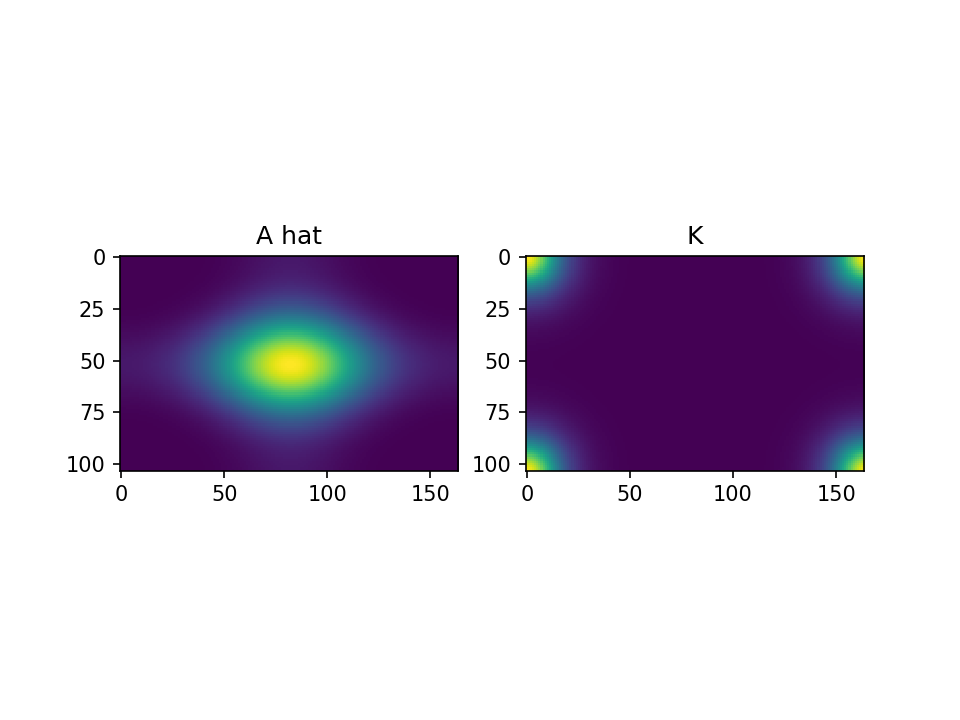

Text(0.5,1,'K')

In [5]:
# encode our energy operator in the Fourier domain using discrete derivatives
f0 = np.arange(nx[0])/(dx[0]*nx[0])
f1 = np.arange(nx[1])/(dx[1]*nx[1])
F0,F1 = np.meshgrid(f0,f1,indexing='ij')
a = 10.0 # a scale in mm
# for mice
a = 5.0*dx[0]
p = 2
Ahat = (1.0 - 2.0*a**2*((np.cos(2.0*np.pi*dx[0]*F0) - 1.0)/dx[0]**2 + (np.cos(2.0*np.pi*dx[1]*F1) - 1.0)/dx[1]**2))**(2.0*p)
Khat = 1.0/Ahat
K = np.fft.ifft2(Khat,nx[:2]).real
f,ax = plt.subplots(1,2)
ax[0].imshow(Ahat)
ax[0].set_title('A hat')
ax[1].imshow(K)
ax[1].set_title('K')


<IPython.core.display.Javascript object>


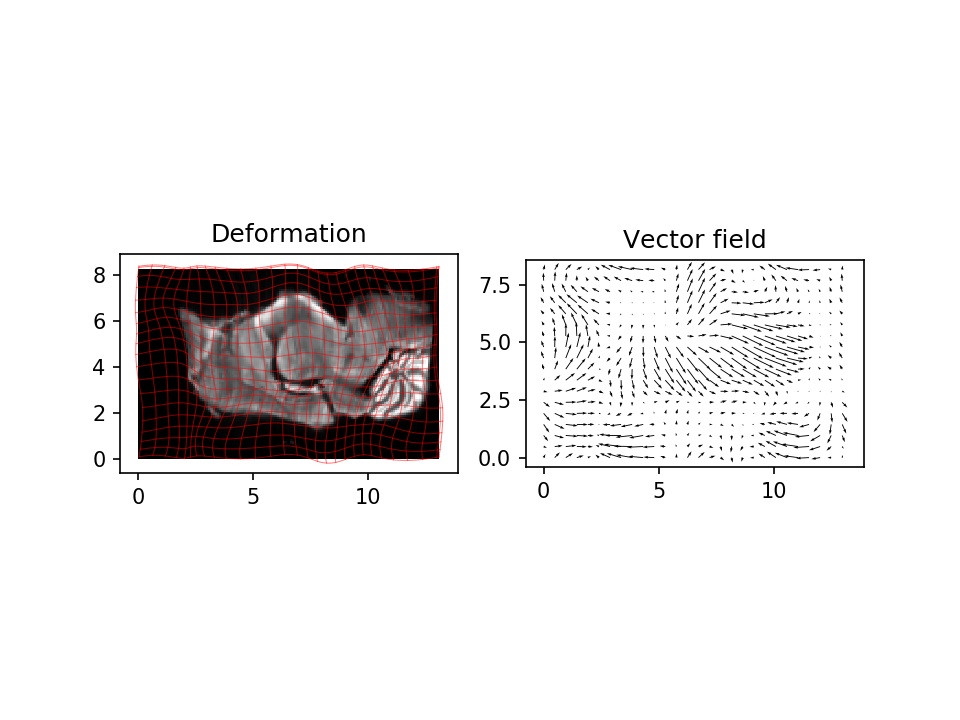

Text(0.5,1,'Vector field')

In [6]:
# generate an example smooth transformation
mag = 5.0e2
# for mouse
mag = 10.0
v0 = np.random.randn(*nx[:2])*mag
v1 = np.random.randn(*nx[:2])*mag
# smooth them with our K
v0 = np.fft.ifft2(np.fft.fft2(v0,nx[:2])*Khat,nx[:2]).real
v1 = np.fft.ifft2(np.fft.fft2(v1,nx[:2])*Khat,nx[:2]).real
phi0 = X0-v0
phi1 = X1-v1
interp_args = {'method':'linear','bounds_error':False,'fill_value':0}
phiI = spi.interpn([x0,x1],I,np.stack([phi0,phi1],axis=-1),**interp_args)

f,ax = plt.subplots(1,2,sharex=True)
stride = 6
imshow_args = dict(cmap='gray',extent=[x1[0],x1[-1],x0[0],x0[-1]],origin='lower')
ax[0].imshow(phiI,**imshow_args)
ss.plot_grid(X1+v1,X0+v0,ax=ax[0],rstride=stride,cstride=stride,color='r',linewidth=0.5,alpha=0.5)
ax[0].set_aspect('equal')
ax[0].set_title('Deformation')
ax[1].quiver(X1[::stride,::stride],X0[::stride,::stride],
             v1[::stride,::stride],v0[::stride,::stride])
ax[1].set_aspect('equal')
ax[1].set_title('Vector field')



<IPython.core.display.Javascript object>


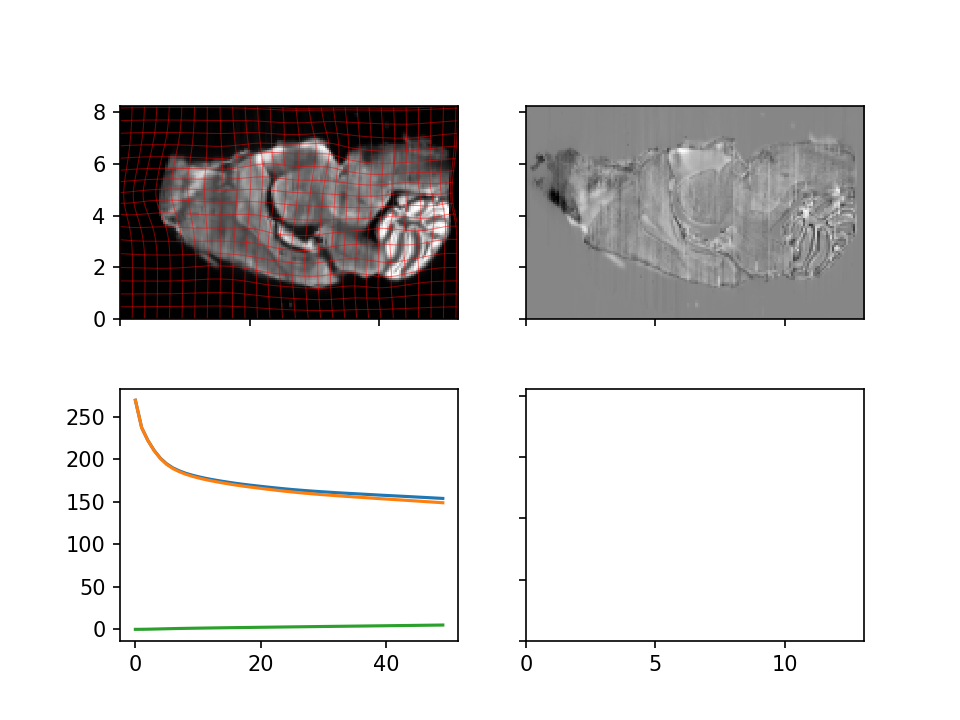

In [7]:
# now run matching
# for display, create plots with shared axis
f,ax = plt.subplots(2,2,sharex=True,sharey=True)
# for plotting energy, no shared axis
f.delaxes(ax[1][0])
ax[1][0] = f.add_subplot(2,2,3)


# parameters
sigma = 2e0
niter = 50
epsilon = 2.0e-2
# for mouse
sigma = 2.0e1
epsilon = 5.0e-3

# initialize
v0 = np.zeros(nx[:2])
v1 = np.zeros(nx[:2])
I_0,I_1 = np.gradient(I,dx[0],dx[1])
EMAll = []
ERAll = []
EAll = []
for it in range(niter):
    # compute the deformed image
    phi0 = X0-v0
    phi1 = X1-v1
    phiI = spi.interpn([x0,x1],I,np.stack([phi0,phi1],axis=-1),**interp_args)
    ax[0,0].cla()
    ax[0,0].imshow(phiI,**imshow_args)
    ss.plot_grid(X1+v1,X0+v0,ax=ax[0,0],color='r',alpha=0.5,linewidth=0.5,rstride=stride,cstride=stride)
    
    # error
    err = phiI - J
    ax[0,1].cla()
    ax[0,1].imshow(err,**imshow_args)
    
    EM = np.sum(err**2/(2.0*sigma**2))*dx[0]*dx[1]
    EMAll.append(EM)
    
    Av0 = np.fft.ifftn(np.fft.fftn(v0)*Ahat).real
    Av1 = np.fft.ifftn(np.fft.fftn(v1)*Ahat).real
    ER = np.sum(v0*Av0 + v1*Av1)*0.5*dx[0]*dx[1]
    ERAll.append(ER)
    
    E = ER+EM
    EAll.append(E)
    ax[1,0].cla()
    ax[1][0].plot(EAll)
    ax[1][0].plot(EMAll)
    ax[1][0].plot(ERAll)
    
    # deform gradient of I
    phiI_0 = spi.interpn([x0,x1],I_0,np.stack([phi0,phi1],axis=-1),**interp_args)
    phiI_1 = spi.interpn([x0,x1],I_1,np.stack([phi0,phi1],axis=-1),**interp_args)
    
    # start building the cost function gradient
    grad0 = -err*phiI_0/sigma**2
    grad1 = -err*phiI_1/sigma**2
    
    # smooth it
    grad0 = np.fft.ifftn(np.fft.fftn(grad0)*Khat).real
    grad1 = np.fft.ifftn(np.fft.fftn(grad1)*Khat).real
    
    # add the regularization term
    grad0 += v0
    grad1 += v1
    
    # update
    v0 -= epsilon*grad0
    v1 -= epsilon*grad1
    
    f.canvas.draw()
    #plt.show()

## Now in 3D
There's really no difference in 3D

In [8]:
# load images
#I = imgI.get_data()[:,:,:,0]
I = AI
down = 3
I = ss.downsample_image(I,down)
nx = I.shape
dx = imgI.header['pixdim'][1:4]*down
J = imgJ.get_data()[:,:,:,0]
J = ss.downsample_image(J,down)
x0 = np.arange(nx[0])*dx[0]
x1 = np.arange(nx[1])*dx[1]
x2 = np.arange(nx[2])*dx[2]
X0,X1,X2 = np.meshgrid(x0,x1,x2,indexing='ij')

<IPython.core.display.Javascript object>


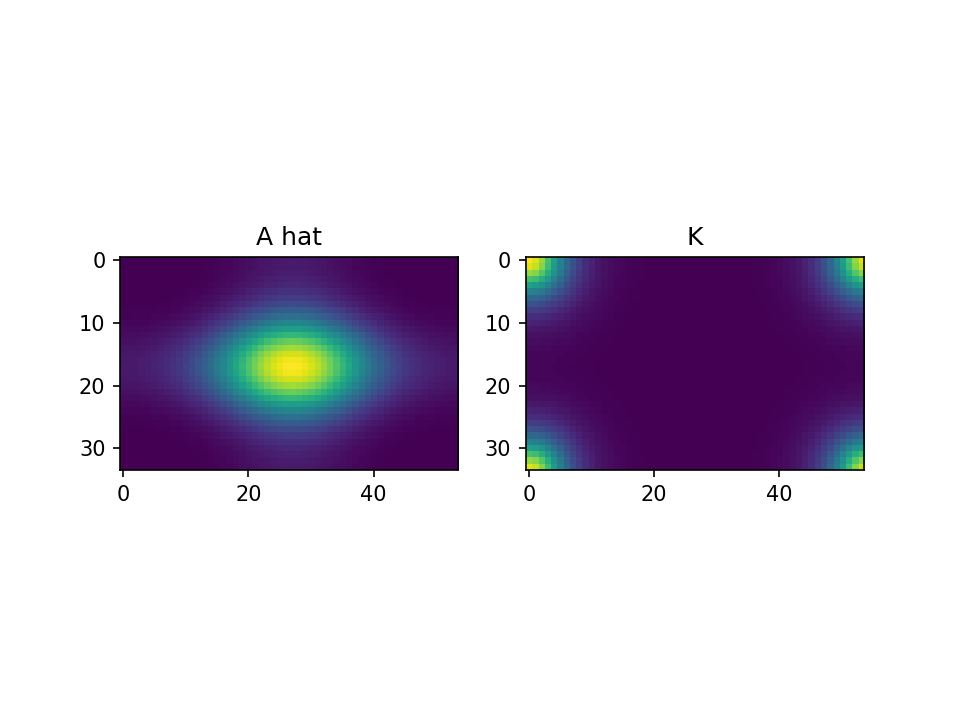

Text(0.5,1,'K')

In [9]:
# encode our energy operator in the Fourier domain using discrete derivatives
f0 = np.arange(nx[0])/(dx[0]*nx[0])
f1 = np.arange(nx[1])/(dx[1]*nx[1])
f2 = np.arange(nx[2])/(dx[2]*nx[2])
F0,F1,F2 = np.meshgrid(f0,f1,f2,indexing='ij')
a = 2.0*dx[0] # a scale in mm
p = 2
Ahat = (1.0 - 2.0*a**2*((np.cos(2.0*np.pi*dx[0]*F0) - 1.0)/dx[0]**2 
                        + (np.cos(2.0*np.pi*dx[1]*F1) - 1.0)/dx[1]**2
                        + (np.cos(2.0*np.pi*dx[2]*F2) - 1.0)/dx[2]**2))**(2.0*p)
Khat = 1.0/Ahat
K = np.fft.ifftn(Khat).real
f,ax = plt.subplots(1,2)
ax[0].imshow(Ahat[:,:,0])
ax[0].set_title('A hat')
ax[1].imshow(K[:,:,0])
ax[1].set_title('K')

<IPython.core.display.Javascript object>


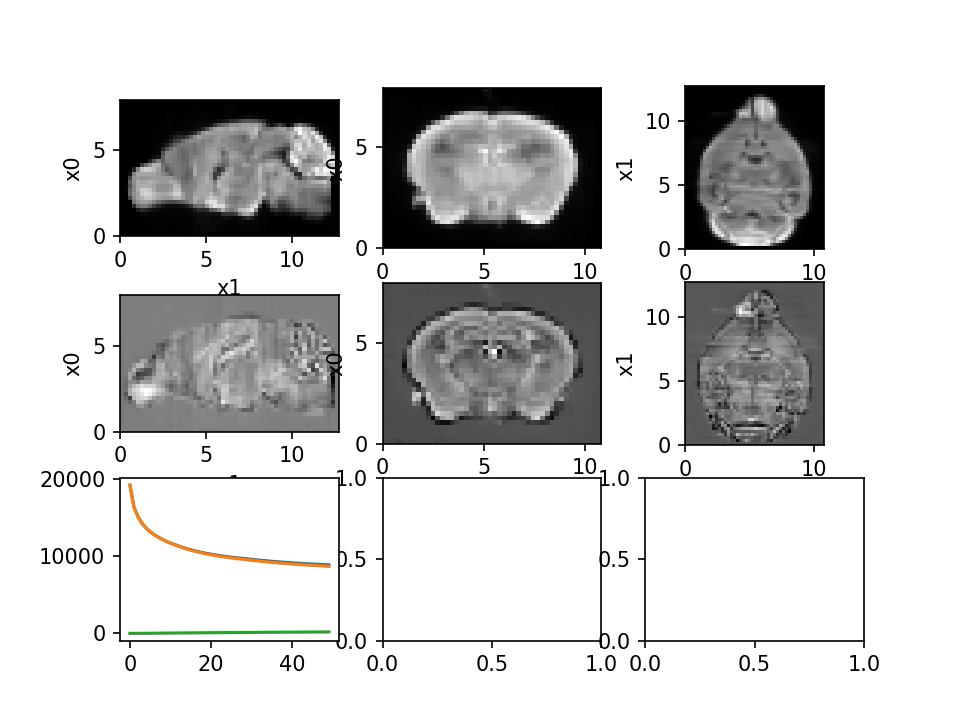

In [10]:
# now run matching
# for display, create plots with shared axis
f,ax = plt.subplots(3,3)
# for plotting energy, no shared axis
f.delaxes(ax[2][0])
ax[2][0] = f.add_subplot(3,3,7)

# parameters
sigma = 2e0
niter = 50
epsilon = 2.0e-2
# for mouse
sigma = 5.0e0
epsilon = 2.0e-3

# initialize
v0 = np.zeros(nx)
v1 = np.zeros(nx)
v2 = np.zeros(nx)
I_0,I_1,I_2 = np.gradient(I,dx[0],dx[1],dx[2])
EMAll = []
ERAll = []
EAll = []
for it in range(niter):
    # compute the deformed image
    phi0 = X0-v0
    phi1 = X1-v1
    phi2 = X2-v2
    phiI = spi.interpn([x0,x1,x2],I,np.stack([phi0,phi1,phi2],axis=-1),**interp_args)
    [a.cla() for a in ax[0]]
    ss.imshow_slices(x0,x1,x2,phiI,ax[0])
    
    # error and cost functions
    err = phiI - J
    [a.cla() for a in ax[1]]
    ss.imshow_slices(x0,x1,x2,err,ax[1])
    
    EM = np.sum(err**2/(2.0*sigma**2))*dx[0]*dx[1]*dx[2]
    EMAll.append(EM)
    
    Av0 = np.fft.ifftn(np.fft.fftn(v0)*Ahat).real
    Av1 = np.fft.ifftn(np.fft.fftn(v1)*Ahat).real
    Av2 = np.fft.ifftn(np.fft.fftn(v2)*Ahat).real
    ER = np.sum(v0*Av0 + v1*Av1 + v2*Av2)*0.5*dx[0]*dx[1]*dx[2]
    ERAll.append(ER)
    
    E = ER+EM
    EAll.append(E)
    ax[2][0].cla()
    ax[2][0].plot(EAll)
    ax[2][0].plot(EMAll)
    ax[2][0].plot(ERAll)
    
    # deform the gradient of I
    phiI_0 = spi.interpn([x0,x1,x2],I_0,np.stack([phi0,phi1,phi2],axis=-1),**interp_args)
    phiI_1 = spi.interpn([x0,x1,x2],I_1,np.stack([phi0,phi1,phi2],axis=-1),**interp_args)
    phiI_2 = spi.interpn([x0,x1,x2],I_2,np.stack([phi0,phi1,phi2],axis=-1),**interp_args)
    
    # start building the cost function gradient
    grad0 = -err*phiI_0/sigma**2
    grad1 = -err*phiI_1/sigma**2
    grad2 = -err*phiI_2/sigma**2
    
    # smooth it
    grad0 = np.fft.ifftn(np.fft.fftn(grad0)*Khat).real
    grad1 = np.fft.ifftn(np.fft.fftn(grad1)*Khat).real
    grad2 = np.fft.ifftn(np.fft.fftn(grad2)*Khat).real
    
    # add the regularization term
    grad0 += v0
    grad1 += v1
    grad2 += v2
    
    # update my vector field
    v0 -= epsilon*grad0
    v1 -= epsilon*grad1
    v2 -= epsilon*grad2
    
    f.canvas.draw()
    #plt.show()